# NOTEBOOK 3f: MODELING - RidgeCV

Now that we have tuned our dataset we will begin optimizing models and allow more feature to contribute to our predictions. Since the ElasticNet algorithm takes on characteristics of both ridge and lasso regression approaches to feature selection, this will be our starting point. If there is a stong indication that one model is favored over the other we can investigate that more fully to compare performance.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pickle
import re
import time

from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFromModel, f_regression, RFECV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

np.random.seed(42)

%matplotlib inline

Loading the clean training data from Notebook 02

In [3]:
df = pd.read_csv('../data/train_clean.csv', index_col='Id', na_filter=False)

In [4]:
df.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Bsmt Unf SF,Total Bsmt SF,Central Air,...,Misc Feature_none,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
Id,,,,,,,,,,,,,,,,,,,,,
109,0.0,13517,6,8,1976,2005,289.0,192.0,725.0,1,...,1,0,0,0,0,0,0,0,0,1
544,43.0,11492,7,5,1996,1997,132.0,276.0,913.0,1,...,1,0,0,0,0,0,0,0,0,1
153,68.0,7922,5,7,1953,2007,0.0,326.0,1057.0,1,...,1,0,0,0,0,0,0,0,0,1
318,73.0,9802,5,5,2006,2007,0.0,384.0,384.0,1,...,1,0,0,0,0,0,0,0,0,1
255,82.0,14235,6,8,1900,1993,0.0,676.0,676.0,1,...,1,0,0,0,0,0,0,0,0,1


In [5]:
X = df.drop(['SalePrice'],axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
model = 'ridge'

In [7]:
pipe = Pipeline([
    ('var_thresh', VarianceThreshold(0)),
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k='all')),
#     ('enet', ElasticNetCV()),
#     ('lasso', LassoCV()),
    ('ridge', RidgeCV(gcv_mode='auto')),
#     ('knn', KNeighborsRegressor),
])


In [8]:
X_train.shape

(1535, 254)

In [44]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k='all', score_func=<function f_regression at 0x1a1bb69620>)), ('ridge', RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
    gcv_mode='auto', normalize=False, scoring=None, store_cv_values=False))])

In [45]:
pipe.score(X_train,y_train)

0.9406974313868397

In [46]:
pipe.score(X_test,y_test)

0.9301760249643415

In [47]:
params = {
#     'var_thresh__threshold': [0,.001,.01,.02,.05],
#     'kbest__k': [5,7,13,17,23,37,53,79,'all'],
    'ridge__alphas': [np.logspace(0,50,200)],
    
}

We will search over 200 values for the optimal alpha value as this hyperparameter has the most impact on this model. Alpha tunes how quickly beta coefficients approach 0 and therefore maximizes the regularization power of this model.

In [48]:
gs = GridSearchCV(pipe, params, cv=5, scoring='r2', verbose=1)

In [49]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k='all', score_func=<function f_regression at 0x1a1bb69620>)), ('ridge', RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
    gcv_mode='auto', normalize=False, scoring=None, store_cv_values=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'ridge__alphas': [array([1.00000e+00, 1.78343e+00, ..., 5.60717e+49, 1.00000e+50])]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [50]:
gs.best_params_

{'ridge__alphas': array([1.00000000e+00, 1.78343088e+00, 3.18062569e+00, 5.67242607e+00,
        1.01163798e+01, 1.80418641e+01, 3.21764175e+01, 5.73844165e+01,
        1.02341140e+02, 1.82518349e+02, 3.25508860e+02, 5.80522552e+02,
        1.03532184e+03, 1.84642494e+03, 3.29297126e+03, 5.87278661e+03,
        1.04737090e+04, 1.86791360e+04, 3.33129479e+04, 5.94113398e+04,
        1.05956018e+05, 1.88965234e+05, 3.37006433e+05, 6.01027678e+05,
        1.07189132e+06, 1.91164408e+06, 3.40928507e+06, 6.08022426e+06,
        1.08436597e+07, 1.93389175e+07, 3.44896226e+07, 6.15098579e+07,
        1.09698580e+08, 1.95639834e+08, 3.48910121e+08, 6.22257084e+08,
        1.10975250e+09, 1.97916687e+09, 3.52970730e+09, 6.29498899e+09,
        1.12266777e+10, 2.00220037e+10, 3.57078596e+10, 6.36824994e+10,
        1.13573336e+11, 2.02550194e+11, 3.61234270e+11, 6.44236351e+11,
        1.14895100e+12, 2.04907469e+12, 3.65438307e+12, 6.51733960e+12,
        1.16232247e+13, 2.07292178e+13, 3.69691

These alpha values are huge, sugesting very strong regularization which indicates an effort to drop some betas to zero. We expect this model to perform poorly compared to lasso.

In [51]:
gs.best_estimator_.named_steps['ridge'].alpha_

580.5225516094896

In [52]:
columns = X.columns
columns = columns[gs.best_estimator_.named_steps['var_thresh'].get_support()]
columns = columns[gs.best_estimator_.named_steps['kbest'].get_support()]

X_weights = pd.DataFrame(gs.best_estimator_.named_steps[f'{model}'].coef_, 
             index = columns, 
             columns=['weight'])
X_weights['abs_weight'] = X_weights['weight'].abs()

In [53]:
X_weights.sort_values(['abs_weight'],ascending=False)

,weight,abs_weight
Roof Matl_ClyTile,-8415.741238,8415.741238
Gr Liv Area,7286.766679,7286.766679
Overall Qual,6810.123151,6810.123151
Misc Feature_Elev,-5968.672599,5968.672599
1st Flr SF,5828.781121,5828.781121
Kitchen Qual_Ex,5737.005833,5737.005833
Total Bsmt SF,5012.538169,5012.538169
Exter Qual_Ex,4598.891785,4598.891785
Neighborhood_NridgHt,4457.640715,4457.640715
BsmtFin SF,4454.329405,4454.329405


In [19]:
def md_coef_table(labels, weights):
    print('| feature | weight |\n| --- | --- |')
    for i in range(len(labels)):
        print(f'| {labels[i]} | {weights[i]:.2e} |')

In [ ]:
weights = X_weights.sort_values('abs_weight', ascending=False)['weight']
labels = weights.index

In [20]:
md_coef_table(labels, weights);

| feature | weight |
| --- | --- |
| Gr Liv Area | 7.00e+16 |
| 2nd Flr SF | -5.88e+16 |
| 1st Flr SF | -5.58e+16 |
| BsmtFin SF 1 | 4.96e+16 |
| Total Bsmt SF | -4.82e+16 |
| Bsmt Unf SF | 4.69e+16 |
| BsmtFin SF 2 | 1.80e+16 |
| Low Qual Fin SF | -7.29e+15 |


In [54]:
beta0 = gs.best_estimator_.named_steps[f'{model}'].intercept_
beta0

180368.8058631922

In [55]:
gs.score(X_train,y_train)

0.9222259395401674

In [56]:
gs.score(X_test,y_test)

0.9265042756043473

The training and test scores align well, suggesting a well-fit model.

In [57]:
preds = gs.predict(X_test)

In [58]:
r2_score(preds, y_test)

0.9160713749893945

In [59]:
(mean_squared_error(preds, y_test))**.5

22497.956721802126

Surprisingly, this model performs better than all but Lasso. This is interesting considering the very large alpha found during the gridsearch optimization. This suggests that with more tuning, the ElasticNet may be a better predictive model.

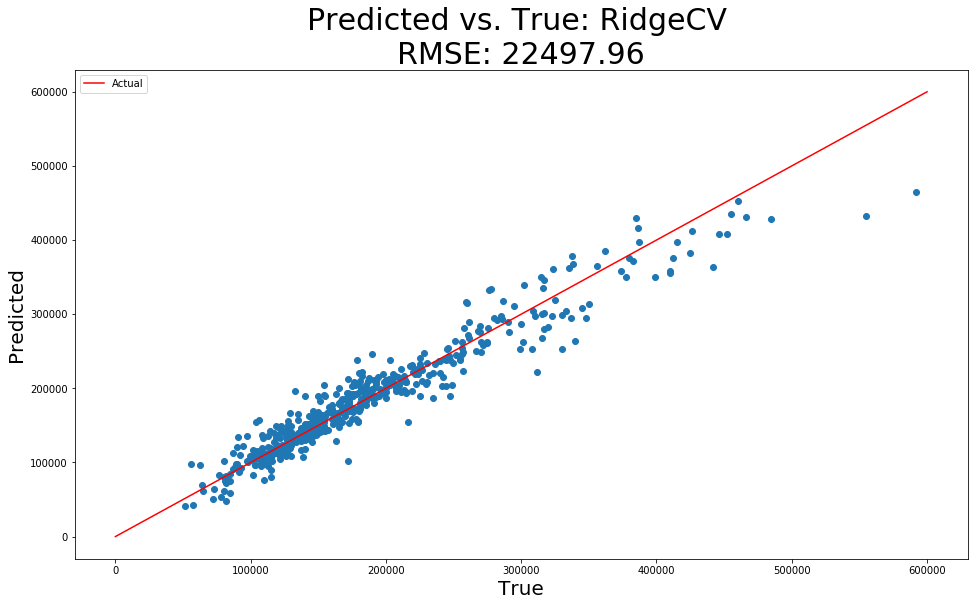

In [60]:
plt.figure(figsize=(16,9))
plt.title(f'Predicted vs. True: RidgeCV \nRMSE: {mean_squared_error(y_test, gs.predict(X_test))**.5:.2f}', fontsize=30);

plt.scatter(y_test, gs.predict(X_test))
plt.plot([0, 600000], [0, 600000], color='r')

plt.ylabel('Predicted', fontsize=20)
plt.xlabel('True', fontsize=20)
plt.legend(['Actual'])
 
    
plt.savefig('../images/ridge_preds_a547.png', dpi=300)

The model seems to manage the outliers best of any model so far. Very conistent error across all values.

## Plotting Beta Weights

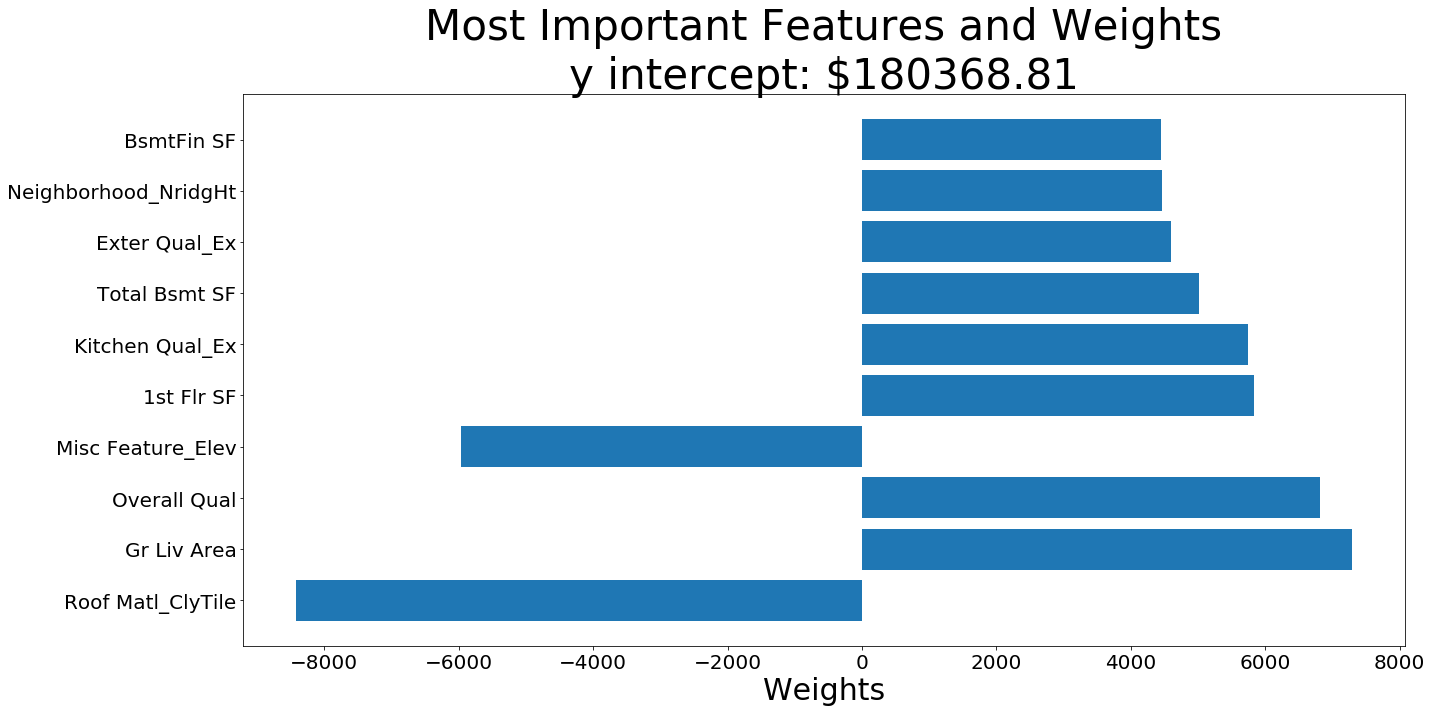

In [61]:
weights = X_weights.sort_values('abs_weight', ascending=False)['weight'].head(10)
beta_0 = gs.best_estimator_.named_steps[f'{model}'].intercept_
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${beta_0:0.02f}', fontsize=42)
plt.tight_layout()

#plt.savefig('../images/ridge_a547.png', dpi=300)

This model puts much less emphasis on garage related features, although Clay Tile does seem to have a surprisingly large negative impact on home value.

In [62]:
X_test.shape

(512, 254)

# Saving out column names and scaled data for use in future models.

Function to save out files with a clear description of each run. Source: Douglas Strodman.

In [39]:
def filename_format_log(file_path, #path for saving out file of interest
                        logfile='../assets/file_log.txt', #default value
                        now=round(time.time()), #time in epoch time
                        file_description=None): 
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() #regx arg to search string for patterns 
                                                                    #(period not followed or preceeded by a period or follows string)
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    formatted_name = f'{file_path[:ext]}_{now}{file_path[ext:]}' #capture everything to (.) and then add (_) time
    if not file_description:
        file_description = input('Please provide a brief description: ')
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

Saving columns that were retained by the model

In [40]:
columns = X_train.columns

In [41]:
formatted_name, now, file_description= filename_format_log('../assets/columns.pkl')

with open(formatted_name, 'wb+') as f:
    pickle.dump(columns, f)

Please provide a brief description:  Ridge a=547


In [42]:
formatted_name, _, _= filename_format_log('../assets/gs.pkl', now=now, file_description=file_description)

with open(formatted_name, 'wb+') as f:
    pickle.dump(gs, f)